In [98]:
# import libraries

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import PowerNorm, LinearSegmentedColormap
import matplotlib.patheffects as path_effects
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# read in data

data = pd.read_csv('../../local_data/TestDataPredictionsRF.csv')
data.columns

# seaborn things

sns.set_context('paper')
sns.set_theme(style="whitegrid", font_scale=1.2)

# and format data

y_true = data["class_id"]
y_pred = data["classification"]

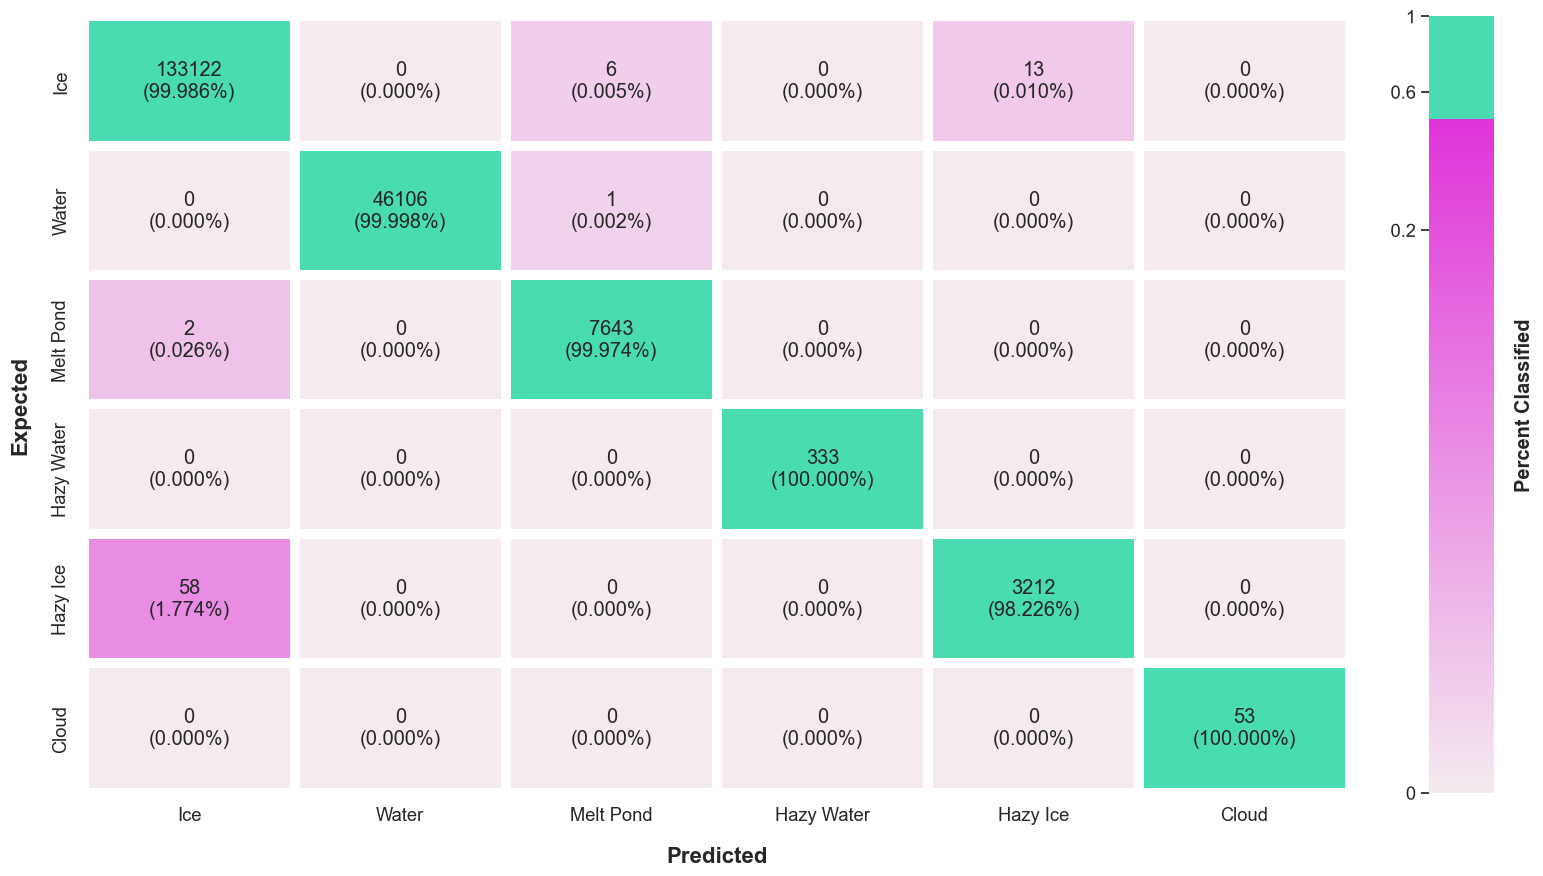

In [102]:
# compute confusion matrix

labels = [1, 2, 3, 4, 5, 6]
cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# create annotation labels (count + percentage)

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i, j]}\n({cm_norm[i, j]:.3%})"

# custom colormap

gamma_val = 0.2
threshold_data = 0.50
threshold_norm = threshold_data ** gamma_val

color_stops = [
    (0.0, "#F4EAEF"),                    # 0%: White
    (threshold_norm - 0.001, "#DF33D9"), # Fades to Pink right up to 94.9%
    (threshold_norm, "#49DCB1"),         # Snaps to Green at exactly 95%
    (1.0, "#49DCB1")                     # Stays Green up to 100%
]
custom_cmap = LinearSegmentedColormap.from_list("PinkGreen", color_stops)

# create figure
class_names = [
    "Ice",
    "Water",
    "Melt Pond",
    "Hazy Water",
    "Hazy Ice",
    "Cloud"
]

plt.figure(figsize=(17, 9))

ax = sns.heatmap(
    cm_norm,
    annot=annot, # Assuming 'annot' and 'cm_norm' are defined in your environment
    fmt="",
    cmap=custom_cmap,
    norm=PowerNorm(gamma=0.2),
    xticklabels=class_names,
    yticklabels=class_names,
    linewidths=6,
    linecolor="white",
    cbar_kws={
        "label": "Percent Classified",
        "aspect": 12,
        "ticks": [0, 0.2, 0.6, 1.0]
    }
)

# Added 'labelpad' to create that teensy bit of extra spacing
ax.set_xlabel("Predicted", fontsize=16, weight="bold", labelpad=16)
ax.set_ylabel("Expected", fontsize=16, weight="bold", labelpad=16)

plt.xticks(rotation=0)
plt.yticks(rotation=90)

# --- Colorbar Customization ---
cbar = ax.collections[0].colorbar

# 1. Update the label strings to match your specified ticks
cbar.set_ticklabels(['0', '0.2', '0.6', '1'])
cbar.ax.yaxis.set_ticks_position('left')

# 3. Add a slight white outline to the inside text so it's readable on both light and dark backgrounds
for label in cbar.ax.get_yticklabels():
    label.set_path_effects([path_effects.withStroke(linewidth=2.5, foreground='white')])

# Make the colorbar title bold and space it out a bit too
cbar.ax.set_ylabel("Percent Classified", weight="bold", labelpad=15)

plt.tight_layout()
plt.show()

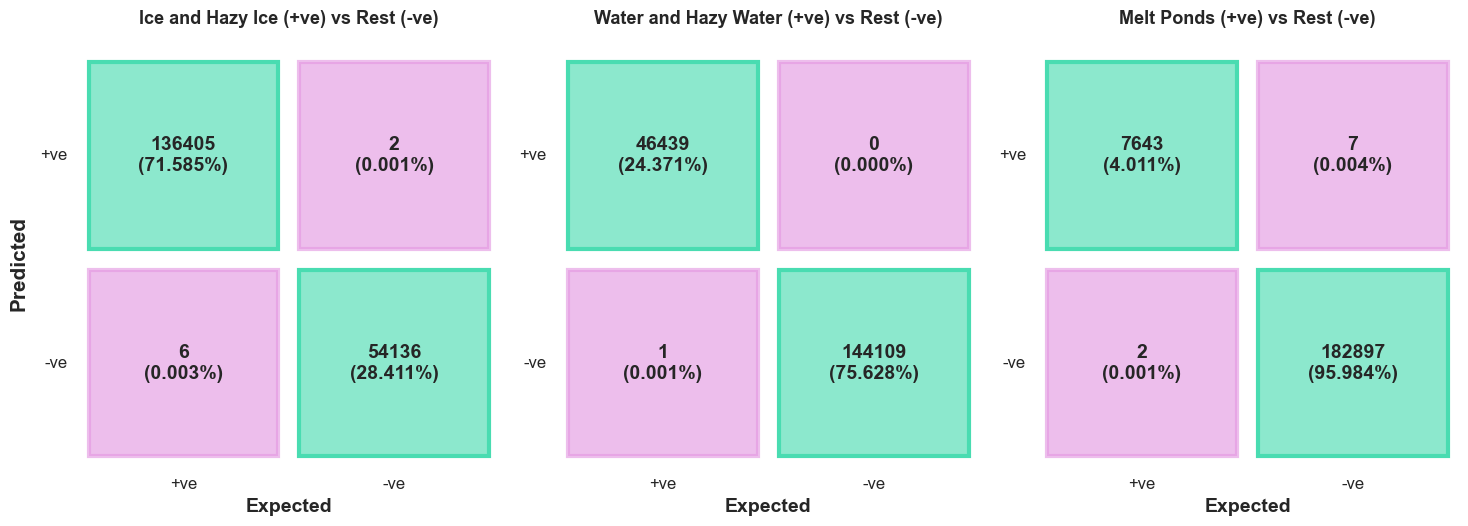

In [100]:
# define classes
groups = {
    "Ice and Hazy Ice (+ve) vs Rest (-ve)": [1, 5],
    "Water and Hazy Water (+ve) vs Rest (-ve)": [2, 4],
    "Melt Ponds (+ve) vs Rest (-ve)": [3]
}

# multiclass confusion matrix
# (Assuming 'data' is already defined in your environment)
y_true = data["class_id"]
y_pred = data["classification"]
labels = sorted(np.unique(np.concatenate((y_true, y_pred))))
cm = confusion_matrix(y_true, y_pred, labels=labels)

# collapse to binary (function)
def collapse_group(cm, positive_classes, labels):
    pos_idx = [labels.index(c) for c in positive_classes]

    # scikit-learn standard: rows = expected, cols = predicted
    TP = cm[np.ix_(pos_idx, pos_idx)].sum()
    
    # Expected positives (rows) that were predicted as something else
    FN = cm[pos_idx, :].sum() - TP
    
    # Expected negatives that were predicted as positive (cols)
    FP = cm[:, pos_idx].sum() - TP
    
    TN = cm.sum() - (TP + FP + FN)

    # Returning formatted for your custom graph: 
    # Row 0 = Predicted +ve (TP, FP)
    # Row 1 = Predicted -ve (FN, TN)
    return np.array([[TP, FP],
                     [FN, TN]])

# create fig
fig, axes = plt.subplots(1, 3, figsize=(15, 5.5))
fig.patch.set_facecolor("white")

for ax, (title, class_group) in zip(axes, groups.items()):
    binary_cm = collapse_group(cm, class_group, labels)

    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor("white")
    
    # Remove default axes borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # draw squares manually
    colors = [
        ("#49DCB1a1", "#49DCB1"),  # TP
        ("#E499E1a1", "#E499E1a1"),  # FP
        ("#E499E1a1", "#E499E1a1"),  # FN
        ("#49DCB1a1", "#49DCB1")   # TN
    ]

    values = binary_cm.flatten()
    total = binary_cm.sum()
    
    # Calculate percentages (protecting against division by zero)
    percentages = (values / total * 100) if total > 0 else np.zeros_like(values)

    idx = 0
    pad = 0.05  # Spacing between squares

    for i in range(2):
        for j in range(2):
            fill_color, edge_color = colors[idx]

            rect = plt.Rectangle(
                (j + pad, i + pad),
                1 - 2 * pad, 
                1 - 2 * pad,
                facecolor=fill_color,
                edgecolor=edge_color,
                linewidth=3
            )
            ax.add_patch(rect)

            # Added the percentage variable to the text formatting
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{values[idx]}\n({percentages[idx]:.3f}%)",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold"
            )

            idx += 1

    ax.set_title(title, fontsize=13, fontweight="bold", pad=20)

    # Expected label and its +ve/-ve indicators
    ax.text(1, 2.15, "Expected", ha="center", va="top", fontsize=14, fontweight="bold")
    ax.text(0.5, 2.05, "+ve", ha="center", va="top", fontsize=12)
    ax.text(1.5, 2.05, "-ve", ha="center", va="top", fontsize=12)

    # Predicted +ve/-ve indicators
    ax.text(-0.05, 0.5, "+ve", va="center", ha="right", fontsize=12)
    ax.text(-0.05, 1.5, "-ve", va="center", ha="right", fontsize=12)

# Add a single master "Predicted" label for the entire figure
fig.supylabel("Predicted", fontsize=15, fontweight="bold")

plt.tight_layout()
plt.show()